# Classification Models

A **classification model** is when you're predicting an outcome with discrete levels. It can be binary (default vs paid off), or multinomial (red, orange, yellow, green, blue, indigo, violet).

We actually estimated a classification model in the last worksheet: Did borrowers pay back a loan?

In this worksheet:

- [ ] Ways to evaluate classifications models
    - You can output a classification report and 5 figures
    - You can use and interpret those outputs
- [ ] The problem of imbalanced data
- [ ] Thinking about the objective: what to maximize and/or minimize in your model   
    

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 50, "display.max_columns", None
)

## Load data 

In [2]:
loans = pd.read_csv('inputs/2013_subsample.zip')

## Create the training and holdout samples

Here, we will use `test_train_split`, though this might not 

In [3]:
# first let's separate y from X (as is typically done)
y = loans.loan_status == "Charged Off"
y.value_counts()
loans = loans.drop("loan_status", axis=1)

# stratify will make sure that test/train both have equal fractions of outcome
X_train, X_test, y_train, y_test = train_test_split(
    loans, y, stratify=y, test_size=0.2, random_state=0
)

## Setting up _one_ classification model

_Note: `preproc_pipe` is the exact same as last time, but I've defined it in a different (easier?) way, and I've named the whole pipeline `clf_logit`_

In [4]:
# set up pipeline to clean each type of variable (1 pipe per var type)

numer_pipe = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

cat_pipe = make_pipeline(OneHotEncoder(drop="first"))

# combine those (make_column_transformer is like make_pipeline, maybe easier on the eyes!)

preproc_pipe = make_column_transformer(
    (numer_pipe, ["annual_inc", "int_rate"]),
    (cat_pipe, ["grade"]),
    remainder="drop",
)

# estimator

clf_logit = make_pipeline(preproc_pipe, LogisticRegression())

I'm going to fit it to the whole training dataset. This means what we're about to learn is being done without CV for now, and will likely result in overconfident performance metrics.

In [5]:
clf_logit.fit(X_train, y_train) 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['annual_inc', 'int_rate']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['grade'])])),
                ('logisticregression', LogisticRegression())])

## Evaluating the classification model

### Classification Report

**The first thing you should do with a classification model is output a `classification_report`.**

_Ignore the Warnings. This table is correct. It's just mad that our model is so bad we never predict a default!_

The definition of precision and recall and f1-score [are here.](https://ledatascifi.github.io/ledatascifi-2022/content/05/03d_whatToMax.html)
- Precision measures: When we predict an outcome, how often does that happen? (Are the predictions precise?)
- Recall: What fraction of an outcome's occurrences does your model detect? ("Does the model recall the true occurrences?")
    - Aka sensitivity: A sensitive model detects an outcome happening more often?
- Accuracy: Fraction of labels that are correct across all observations
- `macro_avg`: Simple average of the stats above the blank line.
    - The average of the precision in the False and True observations here (0.84 and 0) is 0.42
- `weighted_avg`: Average of the stats above the blank line, weighted by the number of observations in each outcome type


In [6]:
print(classification_report(y_train, 
                            clf_logit.predict(X_train)))

              precision    recall  f1-score   support

       False       0.84      1.00      0.92     91024
        True       0.00      0.00      0.00     16819

    accuracy                           0.84    107843
   macro avg       0.42      0.50      0.46    107843
weighted avg       0.71      0.84      0.77    107843



C:\Users\DonsLaptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DonsLaptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DonsLaptop\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Confusion Matrix

**You should also output a Confusion Matrix, which is a standard way to display how a classifier is doing.**
- If you add `normalize='pred'` to the function below, the diagonal elements are your precisions.
- If you add `normalize='true'` to the function below, the diagonal elements are your recalls.

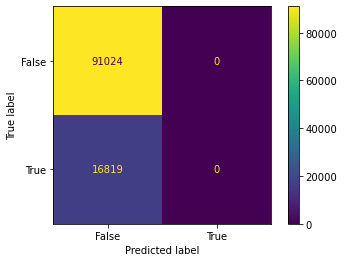

In [7]:
ConfusionMatrixDisplay.from_estimator(clf_logit, X_train, y_train)

### Calibration display

Our logit estimator produces, for each loan, a prediction of the probability of default. A calibration display groups those predictions into buckets (on the x-axis), and reports the average true outcomes for that bucket (on the y-axis). A perfectly calibrated classifier will be on the 45 degree line.

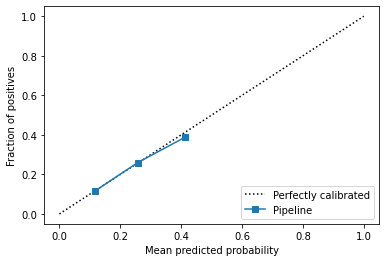

In [8]:
CalibrationDisplay.from_estimator(clf_logit, X_train, y_train)

This figure suggests that our logit seems to be decently "calibrated", even though it is performing AWFULLY in terms of precision and recall on predicting defaults.

Indeed, the logit model is producing predictions that are exactly equal to the average in the data! Look:

In [9]:
clf_logit.predict_proba(X_train)[:,1].mean().round(3)

0.156

What gives? 

Here's what happens:


In [10]:
'''
==============================================================================
          A flow chart from our model to the final predictions:
==============================================================================

logit     >      ahat,           >             yhat           >         {0,1}
                 bhat                        Pr(y=1|X)
      ----------        --------------------           --------------
      | .fit() |        | .predict_proba() |           | .predict() |
      |        |        |  uses ahat bhat  |           |   uses  ?  |
      ----------        --------------------           --------------

'''

'\n==============================================================================\n          A flow chart from our model to the final predictions:\n==============================================================================\n\nlogit     >      ahat,           >             yhat           >         {0,1}\n                 bhat                        Pr(y=1|X)\n      ----------        --------------------           --------------\n      | .fit() |        | .predict_proba() |           | .predict() |\n      |        |        |  uses ahat bhat  |           |   uses  ?  |\n      ----------        --------------------           --------------\n\n'

That last step uses a **"decision function"** that maps the yhat values (predicted probabilities) into predictions. 

To simplify a bit, the **"default threshold"** in `sklearn` for logit is 0.5:
- If yhat>0.5: predict outcome = 1 
- Else: predict outcome = 0


**You don't need to use the default threshold! The threshold is a choice a researcher needs to make, as it involves important tradeoffs.**

In practice, how you make the choice depends on whether your business problem has larger costs for false positives, false negative, or larger benefits for true positives and true negatives.

The next set of diagnostics help you see how changing the threshold can change the performance of the model and assess these tradeoffs.

### Precision-Recall Curves 

This takes all the predicted probabilities the model produces, and pretends we set a threshold of 0.01, 0.02, ... 0.99. For each possible threshold, compute the precision and recall of the predictions, and then plot them all.

In general, this curve will be sloped downwards **because precision and recall are a tradeoff:**
- As you increase the threshold, you'll reduce false positives (more precision) because you only predict default for loans you're very confident will default
- But as you increase the threshold, you'll predict fewer defaults, meaning you'll miss some. This will result in lower recall stats.

The ideal model is the one closest to the upper right corner. (Ouch!)

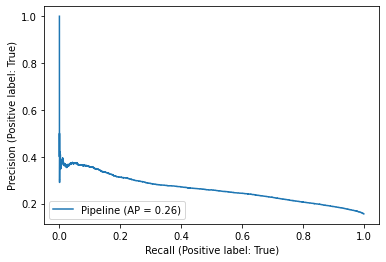

In [11]:
PrecisionRecallDisplay.from_estimator(clf_logit, X_train, y_train)

## ROC curve ("receiver operating characteristic")

This takes all the predicted probabilities the model produces, and pretends we set a threshold of 0.01, 0.02, ... 0.99. For each possible threshold, compute the FPR and the TPR.


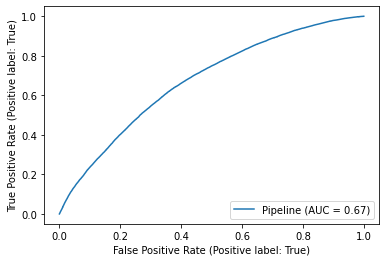

In [12]:
RocCurveDisplay.from_estimator(clf_logit, X_train, y_train)

- This curve shows that you can alter the threshold to reduce false positives, but at the cost of missing some true positives. 
- The perfect estimator is the upper left corner.
- Different estimators will have differently shaped curves, and the closer it gets to the upper left hand corner, the better.
- **"AUC"** reports the area under the curve. 1 is a perfect estimator and 0.5 is a random guess.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/768px-Roc_curve.svg.png"  style="width:50%;"> 




### Detection error tradeoff (DET)

This takes all the predicted probabilities the model produces, and pretends we set a threshold of 0.01, 0.02, ... 0.99. For each possible threshold, compute the FPR and the FNR and plot them.

The perfect estimator is the lower left corner of the chart. (Ouch!)

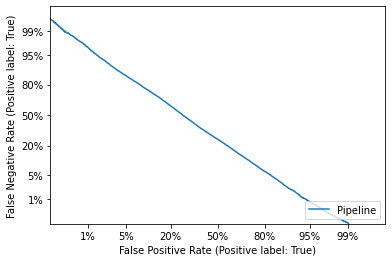

In [13]:
DetCurveDisplay.from_estimator(clf_logit, X_train, y_train)

## The problem with our estimator: Imbalance

The issue that is causing this problem is something that is rampant in real business settings: **"Imbalanced classes."**

Meaning: We have 85% and 15% for our two classes (paid off and charged off) instead of 50/50.

Imbalance causes problems with many (though not all) ML estimators.

By default, `sklearn` treats both outcomes as equally important to predict, which is why it favors the majority class (and always predicts no default).

### Options to deal with imbalanced data

1. Change estimator to "weight" groups equally
    - `class-weight=’balanced’` in tree models and logit
    - Is "like" oversampling, except no slowdown
1. Remove data (meaning: undersample overrepresented group)
    - Throws data away (hurts predictions!) but estimations faster
    - Tradeoff can be worth it: more speed and possibly similar or better predictions
1. Add data (meaning: oversample underrepresented group) 
    - Slower estimations (more data)
    
### 🔥🔥🔥 Practical tips: 🔥🔥🔥

- What works best varies between applications (no "dominant")
- **Try weighting if estimator will let you, then undersampling**

### Weighting example

Denying a loan to a good customer is not as bad as giving a loan to a bad customer that defaults. You should probably _weigh_ defaults more heavily.

The `LogisticRegression()` model has a parameter that lets you decide how you weigh the class's importance. You can manually specific them, but `LogisticRegression(class_weight='balanced')` will cause the minority class to be considered equally important overall. (Maybe you want to weigh even more, which you can do by manually setting the weights.)

So, I'm going to change the pipeline to use that parameter:

In [14]:
clf_logit.get_params() # looking for the name of the parameter, as the pipeline cals it
clf_logit.set_params(logisticregression__class_weight='balanced')

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['annual_inc', 'int_rate']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['grade'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

Now we can use it. How did we do?

In [15]:
clf_logit.fit(X_train, y_train) 
print(classification_report(y_train, 
                            clf_logit.predict(X_train)))

              precision    recall  f1-score   support

       False       0.91      0.57      0.70     91024
        True       0.23      0.69      0.34     16819

    accuracy                           0.59    107843
   macro avg       0.57      0.63      0.52    107843
weighted avg       0.80      0.59      0.65    107843



Hey! We managed to actually predict some defaults!

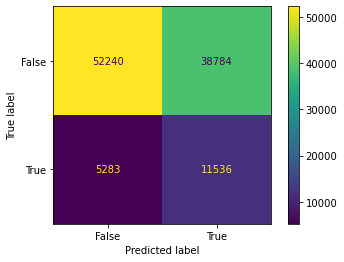

In [16]:
ConfusionMatrixDisplay.from_estimator(clf_logit, X_train, y_train)

## Exercises

Make (reasonable) assumptions as needed to compare the two models:
1. How much money does this improved model save us relative to the prior model from reduced charge-offs?
1. How much foregone profit does this "improved" model have relative to the prior model?
1. How does this improved model do from the standpoint of a profit maximizing lender? Meaning: Would you rather use the first or the second model, and why? 
1. Write down a profit function for firm using the cells of the confusion matrix. (The four cells of the matrix are TNR, TPR, FNR, and FPR.)
1. Based on your profit function, which metric(s) do you want to maximize/minimize in this model? There might not be a clean answer, if so: Discuss candidates and what they capture correctly about the profit function and what they miss.

In [ ]:
# put answers here

## Bonus demo: Undersampling

In [ ]:
# !pip install -U imbalanced-learn

from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler

logit_undersamp = make_pipeline_with_sampler(
    preproc_pipe,
    RandomUnderSampler(random_state=42),
    LogisticRegression(),
)

logit_undersamp.fit(X_train, y_train) 

y_pred = logit_undersamp.predict(X_train,)
print(classification_report(y_train, y_pred))